In [61]:
import pandas as pd
from scipy.stats import ttest_ind
import gdown
import os

In [62]:
file_id = '1BM7QmO4GoR5YxlMPfM5DLyrxBm3mn3oB'
dataset_link = f'https://drive.google.com/uc?id={file_id}'
output_file = 'after_eda_dataset.zip'

In [63]:
if not os.path.exists(output_file):
    gdown.download(dataset_link, output_file, quiet=False)
    print(f"Файл {output_file} скачан.")
else:
    print(f"Файл {output_file} уже существует.")

Файл after_eda_dataset.zip уже существует.


In [64]:
df = pd.read_csv(output_file, compression='zip')

Формулируем гипотезы:

Нулевая гипотеза (H0): Игра с сильнейшим противником не влияет на общее количество ошибок и неточностей.

Альтернативная гипотеза (HA): Игра с сильнейшим противником увеличивает общее количество ошибок и неточностей.

Предпосылки к гипотезе:

Гипотеза о том, что игрок совершает больше ошибок, играя против сильного соперника, базируется на психологических и поведенческих факторах. Игрок испытывает давление, столкнувшись с серьезным оппонентом. Стресс мешает концентрации внимания, снижает точность движений и принятие решений. Противник высокого уровня вызывает желание показать себя лучшим образом, из-за чего игрок может переоценивать риски, предпринимая рискованные действия или наоборот игроки боятся проиграть сильному сопернику и начинают играть чересчур осторожно, стараясь избегать рисков.Поэтому совершается больше ошибок.

In [75]:
# Создание общего числа ошибок для обоих игроков
df['Total_Errors_WHITE'] = df['White_Inaccuracy'] + df['White_Mistake'] + df['White_Blunder']
df['Total_Errors_BLACK'] = df['Black_Inaccuracy'] + df['Black_Mistake'] + df['Black_Blunder']

# Вычисляем разность рейтинга (белый игрок минус черный игрок)
df['Rating_Difference'] = abs(df['White_Rating'] - df['Black_Rating'])

# Выбор порога различия рейтингов для классификации "сильных противников"
rating_difference_threshold = 100

# Группируем матчи на основании разницы в рейтинге
strong_opponent_games = df[df['Rating_Difference'] >= rating_difference_threshold]
weak_or_average_opponent_games = df[df['Rating_Difference'] < rating_difference_threshold]

# Этап 3: Извлекаем суммарные ошибки для обеих групп (отдельно для черных и белых)
total_errors_strong_white = strong_opponent_games['Total_Errors_WHITE'].values
total_errors_strong_black = strong_opponent_games['Total_Errors_BLACK'].values

total_errors_weak_white = weak_or_average_opponent_games['Total_Errors_WHITE'].values
total_errors_weak_black = weak_or_average_opponent_games['Total_Errors_BLACK'].values


Проверка на нормальность распределения и расчет однородности дисперсии

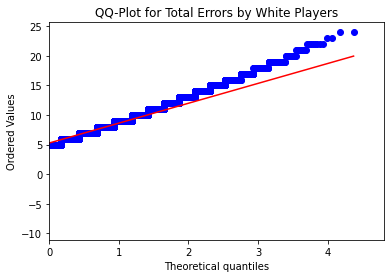

In [76]:
from scipy import stats
import matplotlib.pyplot as plt

# Q-Q plot
stats.probplot(df['Total_Errors_WHITE'], dist="norm", plot=plt)
plt.xlim(left=0)
plt.title("QQ-Plot for Total Errors by White Players")
plt.show()

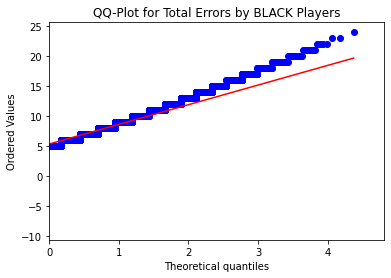

In [77]:
# Q-Q plot
stats.probplot(df['Total_Errors_BLACK'], dist="norm", plot=plt)
plt.xlim(left=0)
plt.title("QQ-Plot for Total Errors by BLACK Players")
plt.show()


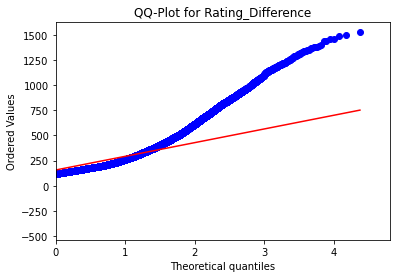

In [78]:
# Q-Q plot
stats.probplot(df['Rating_Difference'], dist="norm", plot=plt)
plt.xlim(left=0)
plt.title("QQ-Plot for Rating_Difference")
plt.show()

In [79]:
# Определение и проведение теста Колмогорова-Смирнова для белого цвета
ks_stat_white, ks_pval_white = stats.kstest(df['Total_Errors_WHITE'], 'norm')

# Определение и проведение теста Колмогорова-Смирнова для черного цвета
ks_stat_black, ks_pval_black = stats.kstest(df['Total_Errors_BLACK'], 'norm')

# Определение и проведение теста Колмогорова-Смирнова для черного цвета
ks_stat_Rating, ks_pval_Rating = stats.kstest(df['Rating_Difference'], 'norm')

# Выведем результаты
print(f"Критерий Колмогорова-Смирнова для белых:")
print(f"Статистика: {ks_stat_white:.4f}, P-значение: {ks_pval_white:.4f}")

print("\nКритерий Колмогорова-Смирнова для черных:")
print(f"Статистика: {ks_stat_black:.4f}, P-значение: {ks_pval_black:.4f}")
      
print("\nКритерий Колмогорова-Смирнова для рейтинга:")
print(f"Статистика: {ks_stat_Rating:.4f}, P-значение: {ks_pval_Rating:.4f}")     

Критерий Колмогорова-Смирнова для белых:
Статистика: 0.8397, P-значение: 0.0000

Критерий Колмогорова-Смирнова для черных:
Статистика: 0.8561, P-значение: 0.0000

Критерий Колмогорова-Смирнова для рейтинга:
Статистика: 0.9856, P-значение: 0.0000


In [80]:
variance_white_errors = df['Total_Errors_WHITE'].var(ddof=1)  # ddof=1 для выборочной дисперсии
variance_rating_difference = df['Rating_Difference'].var(ddof=1)
variance_black_errors = df['Total_Errors_BLACK'].var(ddof=1)

# Выводим результаты
print(f"Дисперсия Total_Errors_WHITE: {variance_white_errors:.4f}")
print(f"Дисперсия Rating_Difference: {variance_rating_difference:.4f}")
print(f"Дисперсия Total_Errors_BLACK: {variance_black_errors:.4f}")

Дисперсия Total_Errors_WHITE: 11.7629
Дисперсия Rating_Difference: 23679.6999
Дисперсия Total_Errors_BLACK: 11.2188


Данные не являются нормально распределенными и дисперсии не равны, поэтому используем U-критерий Манна-Уитни.


In [81]:
from scipy.stats import mannwhitneyu

# Применяем U-критерий Манна-Уитни для белых игроков
statistic, p_value = mannwhitneyu(total_errors_strong_white, total_errors_weak_white, alternative='greater')

# Выводим результаты
print(f"U-statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05  # уровень значимости
if p_value < alpha:
    print("Отвергнута нулевая гипотеза: существует значимая разница в количестве ошибок.")
    print("Выводы: Игра с сильнейшим противником увеличивает количество ошибок.")
else:
    print("Нулевая гипотеза не отвергнута: доказательств влияния силы соперника на увеличение ошибок недостаточно.")

U-statistic: 1546952230.0000
P-value: 0.9775
Нулевая гипотеза не отвергнута: доказательств влияния силы соперника на увеличение ошибок недостаточно.


In [82]:
# Применяем U-критерий Манна-Уитни для белых игроков
statistic, p_value = mannwhitneyu(total_errors_strong_black, total_errors_weak_black, alternative='greater')

# Выводим результаты
print(f"U-statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05  # уровень значимости
if p_value < alpha:
    print("Отвергнута нулевая гипотеза: существует значимая разница в количестве ошибок.")
    print("Выводы: Игра с сильнейшим противником увеличивает количество ошибок.")
else:
    print("Нулевая гипотеза не отвергнута: доказательств влияния силы соперника на увеличение ошибок недостаточно.")

U-statistic: 1537265774.5000
P-value: 0.9999
Нулевая гипотеза не отвергнута: доказательств влияния силы соперника на увеличение ошибок недостаточно.


ВЫВОД:

По нашему тесту видно, что не существует прямой зависимости между силой игрока и количеством допускаемых ошибок при игре с ним при любой разнице в рейтинге. 